# Histograms of track parameters grouped by categories

In [1]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import string

from common_defs import nyr, aliases
import mypaths
from plot_utils import iletters

from octant.core import TrackRun, OctantTrack
from octant.misc import SUBSETS
import octant
octant.__version__

'0.0.11'

In [2]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
subset_aliases = {'all': 'All', **aliases}

In [4]:
plt.style.use('paperfig.mplstyle')

In [5]:
dset_names = (
    ('era5_run000', 'ERA5, CTRL'),
)

In [6]:
track_runs = dict()
for (dset_name, _) in dset_names:
    TR = TrackRun()
    TR.data = OctantTrack.from_mux_df(pd.read_parquet(mypaths.procdir / f'{dset_name}_2008_2017_top10.parquet', engine='pyarrow'))
    TR.is_categorised = True
    track_runs[dset_name] = TR

In [7]:
# vo_per_track = (TR['moderate'].groupby('track_idx')
#                             .apply(lambda x: x.max_vort))
# vo_thresh = np.percentile(vo_per_track, 90)
# strong = vo_per_track[vo_per_track > vo_thresh]
# TR.data.loc[strong.index, 'cat'] = TR.cats['strong']
TR.size('strong')

In [9]:
subsets = SUBSETS

In [10]:
vrbl_dict = dict(
    gen_lys_dist_km=dict(bins=np.linspace(0, 2000, 11), title='Genesis-lysis distance [km]'),
    lifetime_h=dict(bins=np.linspace(0, 72, 13), title='Life time [h]'),
    max_vort=dict(bins=np.linspace(0, 10, 11), title='Maximum vorticity [$10^{-4}$ $s^{-1}$]'),
    total_dist_km=dict(bins=np.linspace(0, 3200, 9), title='Total distance [km]'),
    average_speed=dict(bins=np.linspace(0, 80, 11), title='Propagation velocity [$km$ $h^{-1}$]'),
    area=dict(bins=np.linspace(0, 400, 9), title='Approx. diameter [km]'),
)

In [11]:
track_summary = {}
for subset in subsets:
    track_summary[subset] = pd.DataFrame([[getattr(ct, vrbl_name) if vrbl_name != 'area' else 2*(getattr(ct, vrbl_name).mean()/np.pi)**0.5
                                           for vrbl_name in vrbl_dict.keys()]
                                          for i, ct in TR[subset].groupby('track_idx')],
                                          columns=vrbl_dict.keys())
    track_summary[subset].max_vort *= 1e4

In [12]:
plt_kw_list = [
#     dict(color='C7', alpha=0.2),
    dict(color='C7', alpha=0.4),
    dict(color='#8DBAD7'),#, linewidth=2/3, edgecolor='#111111'),
    dict(color='C0'),#, linewidth=2/3, edgecolor='#111111')
]

In [13]:
vrbl_dict = dict(
    gen_lys_dist_km=dict(bins=np.linspace(0, 2000, 6), title='Genesis-lysis distance [km]'),
    lifetime_h=dict(bins=np.linspace(0, 72, 5), title='Life time [h]'),
    max_vort=dict(bins=np.linspace(0, 10, 6), title='Maximum vorticity [$10^{-4}$ $s^{-1}$]'),
    total_dist_km=dict(bins=np.linspace(0, 3200, 5), title='Total distance [km]'),
    average_speed=dict(bins=np.linspace(0, 80, 6), title='Propagation velocity [$km$ $h^{-1}$]'),
    area=dict(bins=np.linspace(0, 400, 5), title='Approximate diameter [km]'),
)

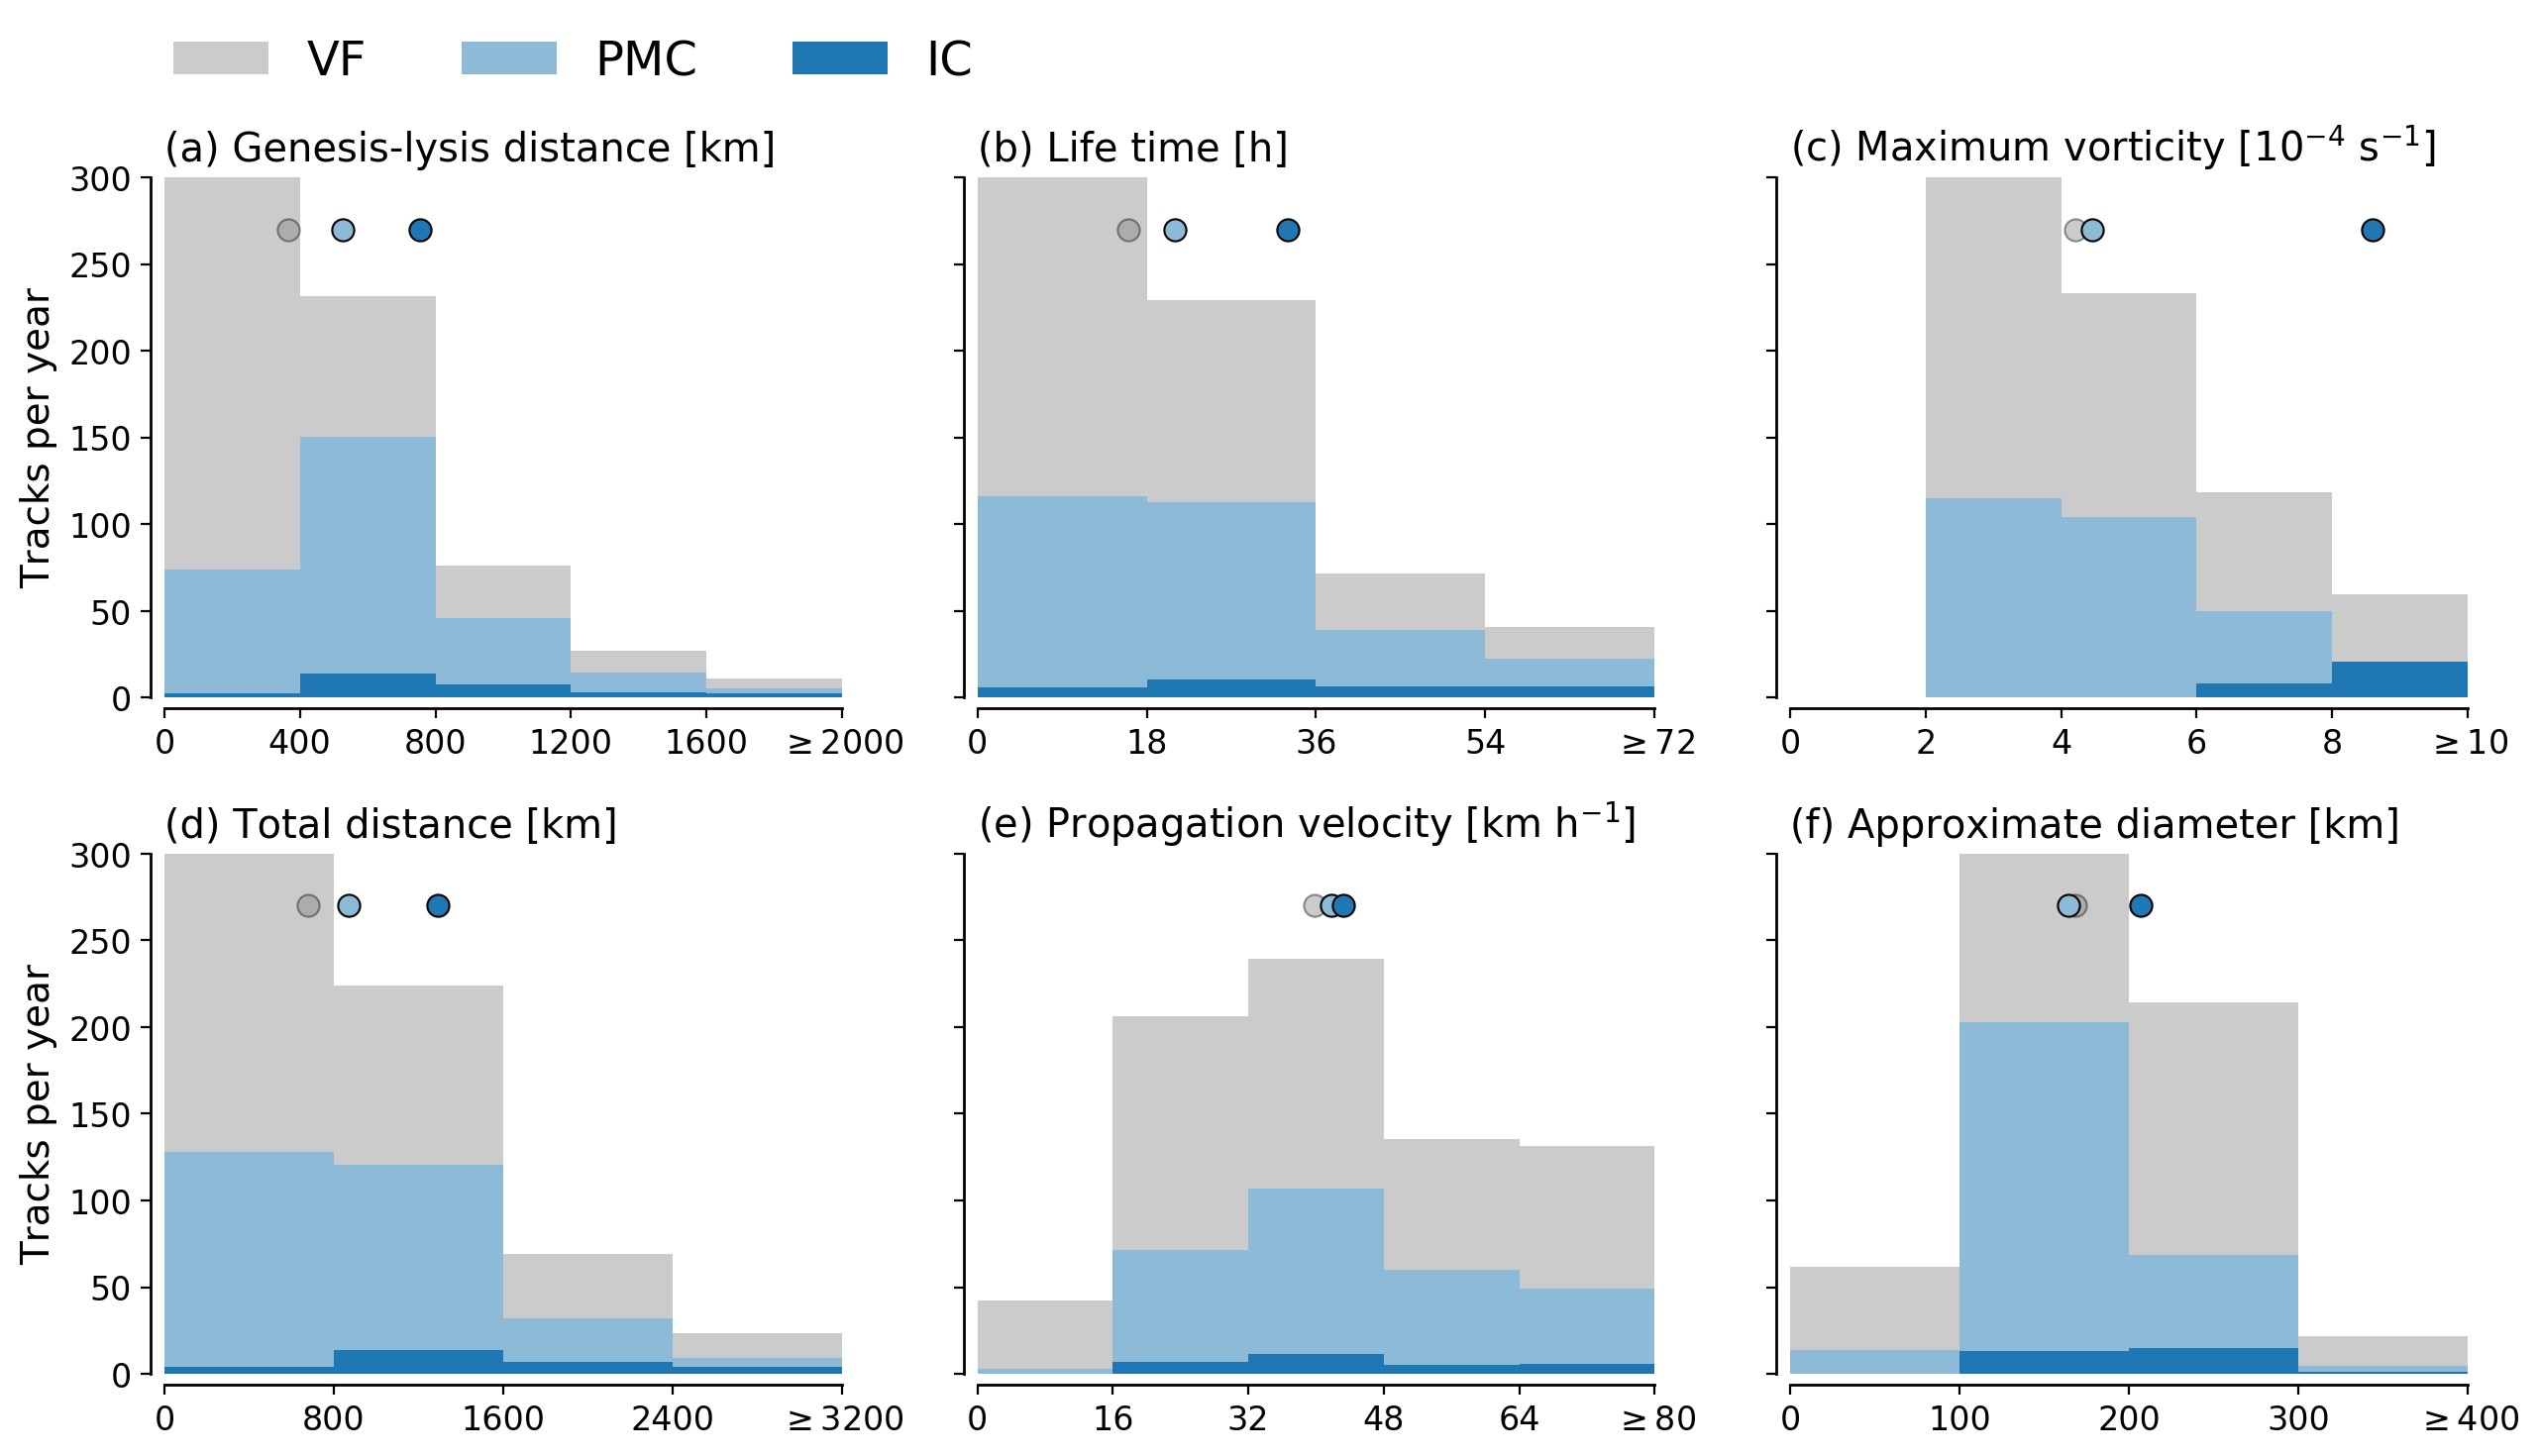

In [16]:
# import string
iletters = iter(string.ascii_lowercase)

ymax = 300

ncols = 3
nrows = 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, gridspec_kw=dict(hspace=0.3, wspace=0.2))

for ax, (vrbl_name, h_kw) in zip(axs.flat, vrbl_dict.copy().items()):
    hist_kw = h_kw.copy()
    ttl = hist_kw['title']
    bins = hist_kw['bins']
    for subset, plt_kw in zip(subsets, plt_kw_list):
        clipped_data = np.clip(track_summary[subset][vrbl_name], bins[0], bins[-1])
        clipped_data.hist(ax=ax, label=subset_aliases[subset], weights=np.ones(clipped_data.shape) * 1/nyr, bins=bins, **plt_kw)
        med_val = np.percentile(track_summary[subset][vrbl_name], 50)
        ax.plot(med_val, 0.9*ymax, alpha=plt_kw.get('alpha', 1),
                mfc=plt_kw['color'], marker='o', ms=8, mec='k', mew=0.75, zorder=100)
    ax.set_xlim(bins[0], bins[-1])
    ax.set_xticks(bins)
    xlabels = [f'{int(x)}' for x in bins]
    xlabels[-1] = f'$\geq {xlabels[-1]}$'
    ax.set_xticklabels(xlabels, rotation=0)
    ax.grid(False)
    ax.set_ylim(0, ymax)
#     ax.set_yscale('log')
    ax.set_title(f'({next(iletters)}) {ttl}', loc='left', fontsize='large')
#     ax.add_artist(AnchoredText(f'({next(iletters)})', loc=1, frameon=True))
    
    for spine in ax.spines.values():
        if spine.spine_type in ['top', 'right']:
            spine.set_linewidth(0)
        else:
            spine.set_linewidth(1)
            spine.set_position(('axes', -0.02))
            spine.set_position(('axes', -0.02))
    
for axrow in axs:
    axrow[0].set_ylabel('Tracks per year')
axs.flatten()[0].legend(fontsize='x-large', ncol=4, loc=2, bbox_to_anchor=(-0.05, 1.35), frameon=False);

In [17]:
fig.savefig(mypaths.plotdir / f'pmctrack_cats_stats_{dset_name}_top10')